# Прогнозирование уровня средней заработной платы в России

Придерживайтесь стандартного алгоритма построения прогноза:

1. Визуальный анализ ряда

2. Стабилизация дисперсии (при необходимости)

3. Выбор порядка дифференцирования

4. Выбор начальных приближений для p, q, P, Q

5. Обучение и сравнение моделей-кандидатов, выбор победителя

6. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Q.

7. Прогнозирование с помощью финальной модели.

In [4]:
from google.colab import drive


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd 'drive/MyDrive/Workspace/coursera/Машинное обучение и анализ данных/5. Прикладные задачи анализа данных/week_1'

[Errno 2] No such file or directory: 'drive/MyDrive/Workspace/coursera/Машинное обучение и анализ данных/5. Прикладные задачи анализа данных/week_1'
/content/drive/MyDrive/Workspace/coursera/Машинное обучение и анализ данных/5. Прикладные задачи анализа данных/week_1


In [100]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product
import warnings

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [8]:
df = pd.read_csv('WAG_C_M.csv', sep=';')
df.head(3)

,month,WAG_C_M
0,01.01.1993,15.3
1,01.02.1993,19.1
2,01.03.1993,23.6


In [9]:
df['month'] = pd.to_datetime(df['month'], format='%d.%m.%Y')

## 1. Визуальный анализ ряда

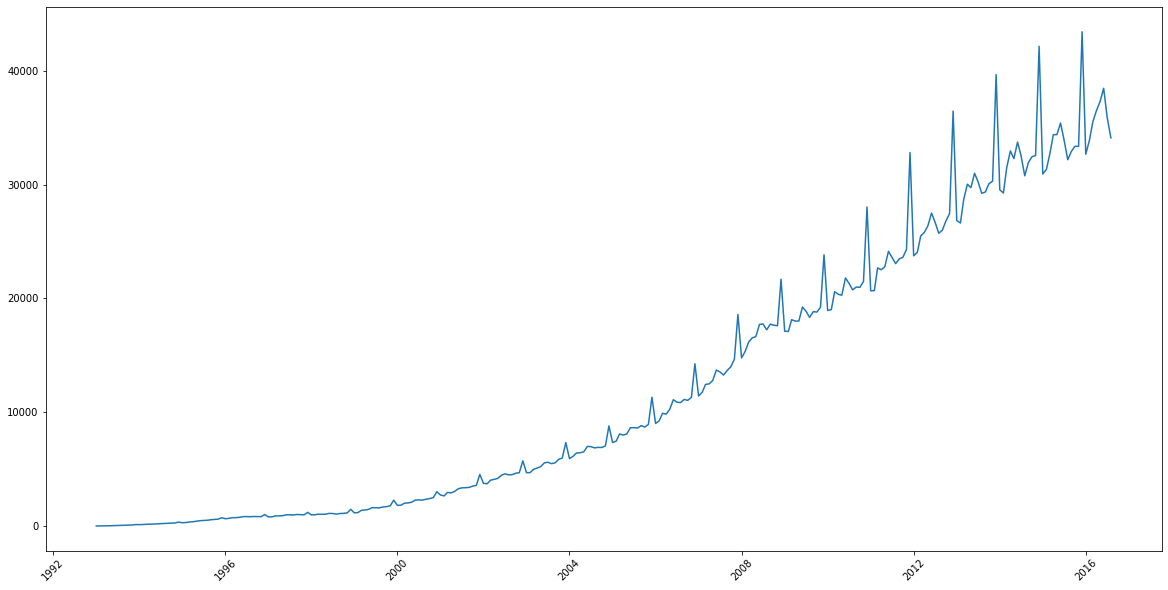

In [44]:
plt.figure(figsize=(20, 10))
plt.plot(df['month'], df['WAG_C_M'])
plt.xticks(rotation=45)
plt.show()

In [14]:
ts = df['WAG_C_M'].copy()
ts.index = df['month']

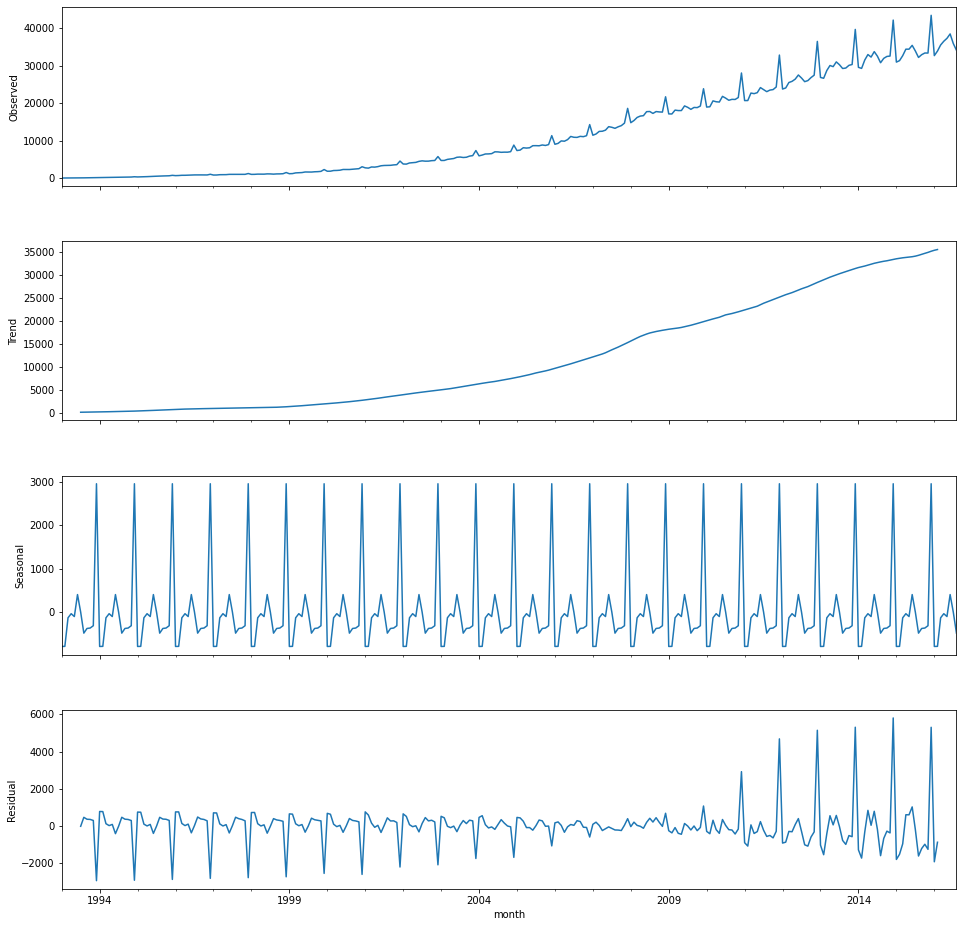

Критерий Дики-Фуллера: p=0.991850


In [35]:
dec = sm.tsa.seasonal_decompose(ts)
fig = dec.plot()
fig.set_figwidth(15)
fig.set_figheight(15)
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ts)[1])

Ряд нестационарен по критерию Дики-Фуллера, в данных есть тренд и мультипликативная сезонность. Необходимо провести дифференцирование и преобразование Бокса-Кокса.

## 2. Стабилизация дисперсии

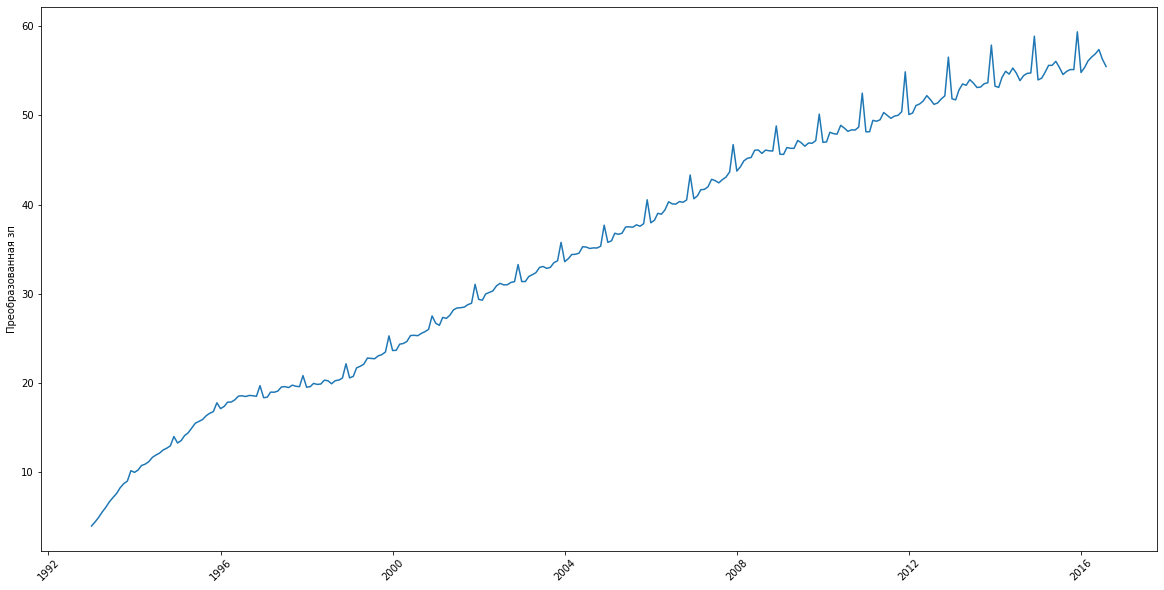

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


In [63]:
ts_boxcox, lmbda = stats.boxcox(ts)
ts_boxcox = pd.Series(data=ts_boxcox, index=ts.index)
plt.figure(figsize=(20, 10))
plt.plot(ts_boxcox)
plt.xticks(rotation=45)
plt.ylabel('Преобразованная зп')
plt.show()
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ts_boxcox)[1])

## 3. Выбор порядка дифференцирования

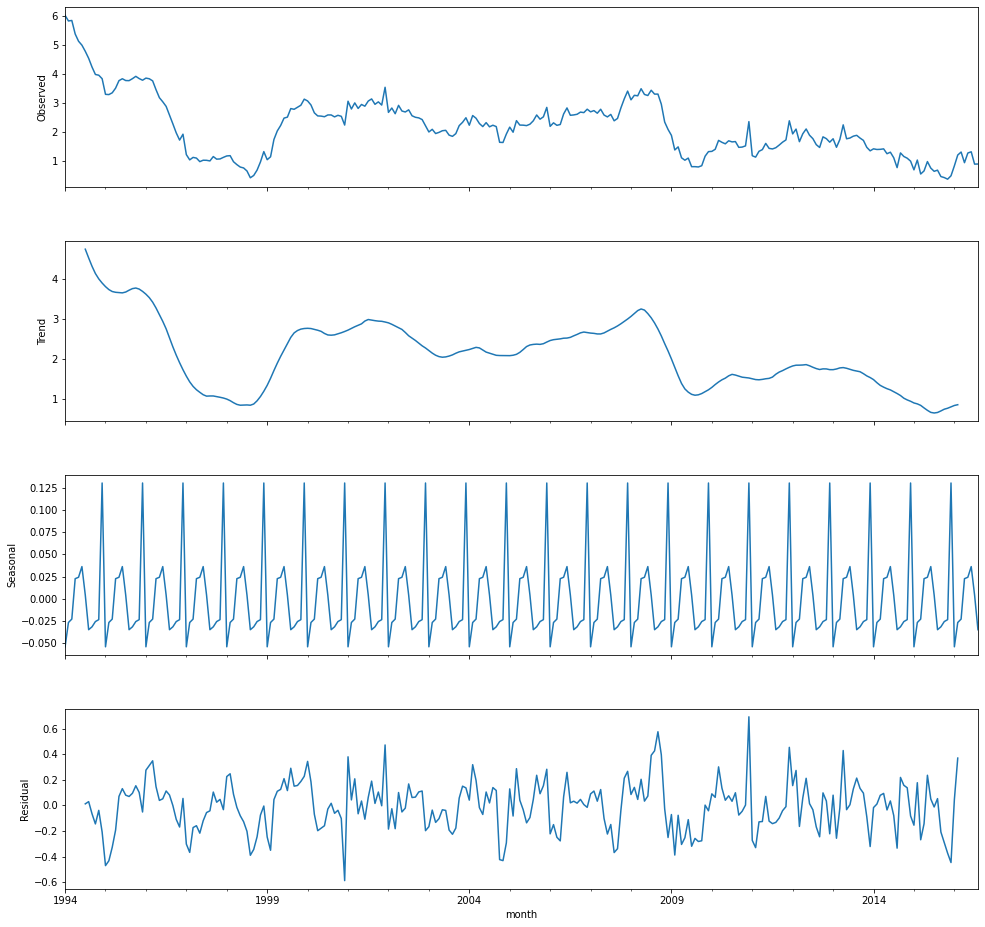

Критерий Дики-Фуллера: p=0.014697


In [66]:
ts_diff = ts_boxcox - ts_boxcox.shift(12)
ts_diff.dropna(inplace=True)
dec = sm.tsa.seasonal_decompose(ts_diff)
fig = dec.plot()
fig.set_figwidth(15)
fig.set_figheight(15)
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ts_diff)[1])

После преобразования Бокса-Кокса и сезонного дифференцирования в ряде по-прежнему присутствует тренд. Добавим также обычное дифференцирование.

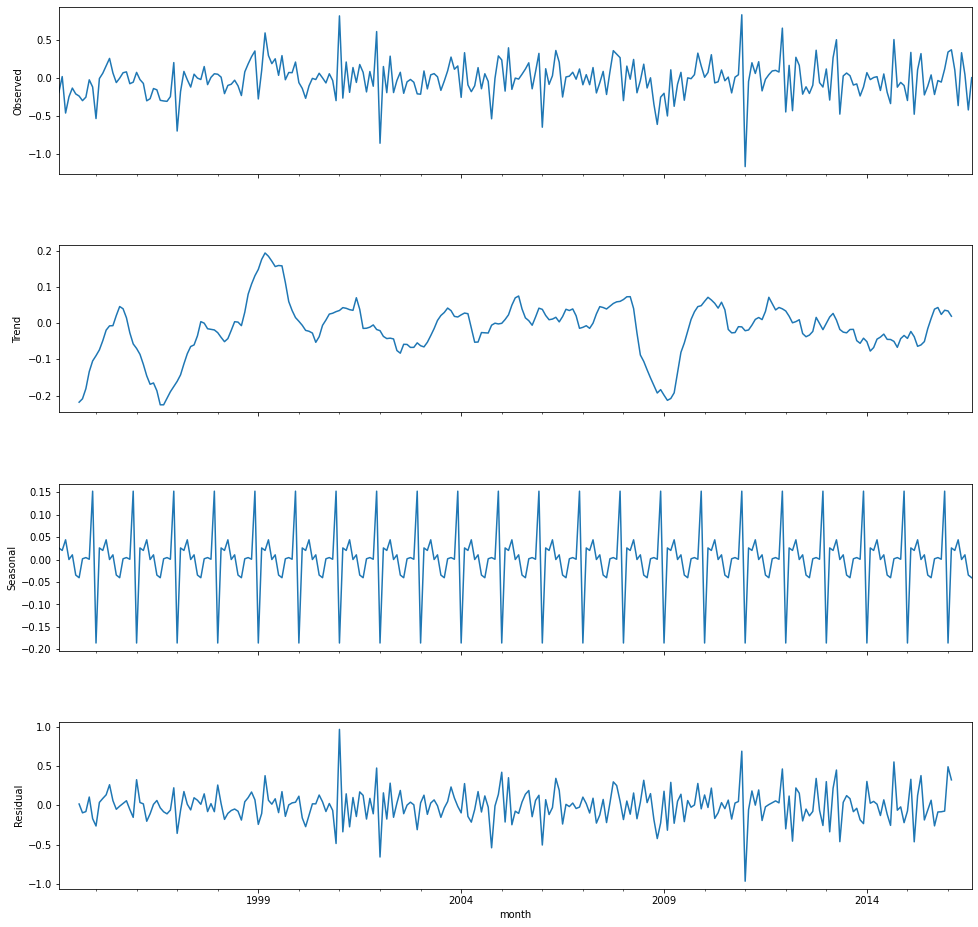

Критерий Дики-Фуллера: p=0.000000


In [67]:
ts_diff = ts_diff - ts_diff.shift(1)
ts_diff.dropna(inplace=True)
dec = sm.tsa.seasonal_decompose(ts_diff)
fig = dec.plot()
fig.set_figwidth(15)
fig.set_figheight(15)
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ts_diff)[1])

От тренда удалось избавиться, перейдем к построению модели временного ряда.

## 4. Выбор начальных приближений для p, q, P, Q

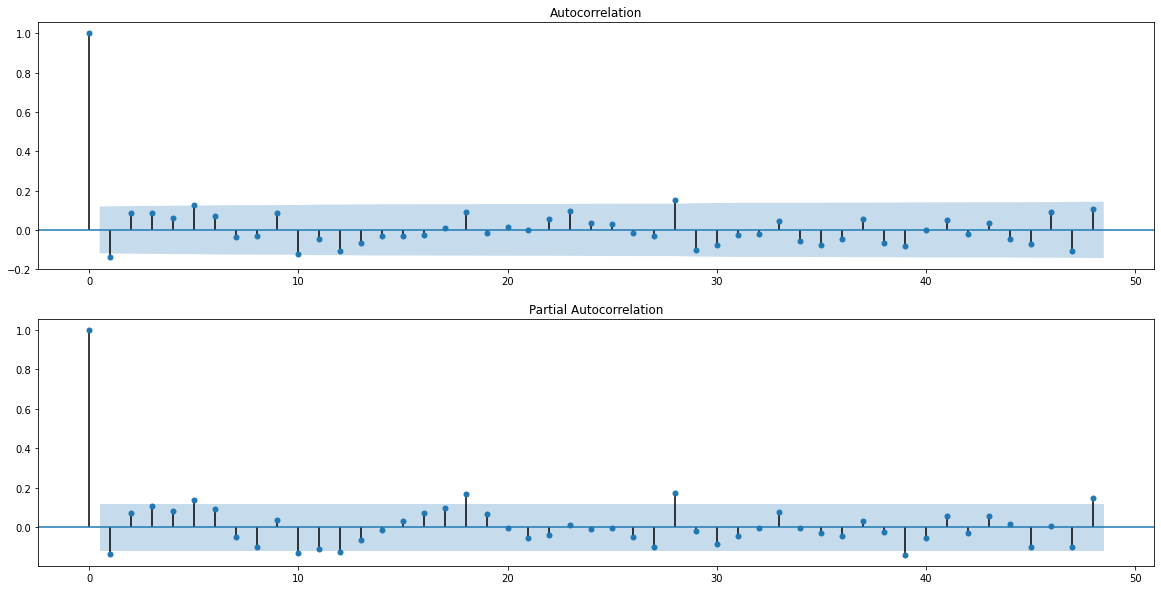

In [76]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sm.graphics.tsa.plot_acf(ts_diff, lags=48, ax=ax[0])
sm.graphics.tsa.plot_pacf(ts_diff, lags=48, ax=ax[1])
plt.show()

Выбраны следующие начальные приближения параметров

In [79]:
d = 1
D = 1

Q = range(0, 1)
qs = range(0, 2)

Ps = range(0, 2)
ps = range(0, 5)

## 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [80]:
parameters = product(ps, qs, Ps, Q)
parameters_list = list(parameters)
len(parameters_list)

20

In [91]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(ts_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 9.6 s, sys: 7 s, total: 16.6 s
Wall time: 8.55 s


In [92]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
15  (3, 1, 1, 0) -4.995858
19  (4, 1, 1, 0) -3.975974
11  (2, 1, 1, 0) -3.884138
14  (3, 1, 0, 0) -1.392773
10  (2, 1, 0, 0) -1.355269


## 6. Анализ остатков построенной модели

In [95]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  284
Model:             SARIMAX(3, 1, 1)x(1, 1, 0, 12)   Log Likelihood                   8.498
Date:                            Sat, 22 Jan 2022   AIC                             -4.996
Time:                                    20:43:36   BIC                             16.617
Sample:                                01-01-1993   HQIC                             3.682
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4852      0.210      2.311      0.021       0.074       0.897
ar.L2          0.1630      0.075   

Критерий Стьюдента: p=0.281810
Критерий Дики-Фуллера: p=0.000000


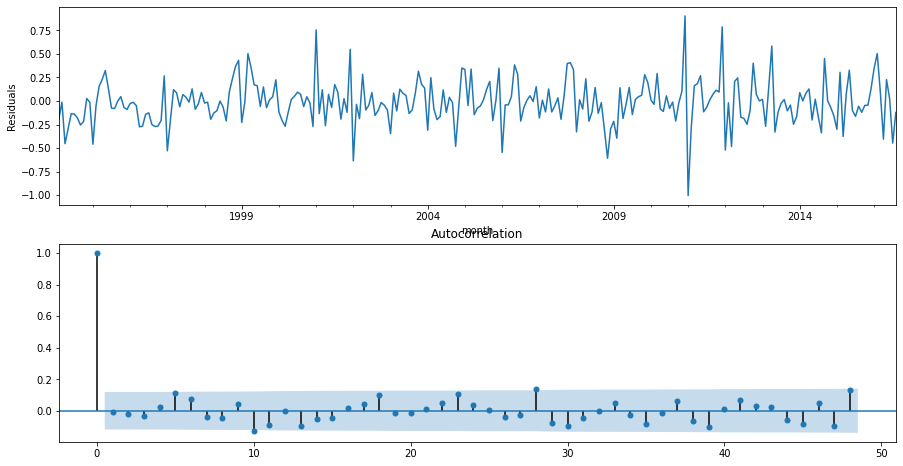

In [96]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

## 7. Прогнозирование с помощью финальной модели

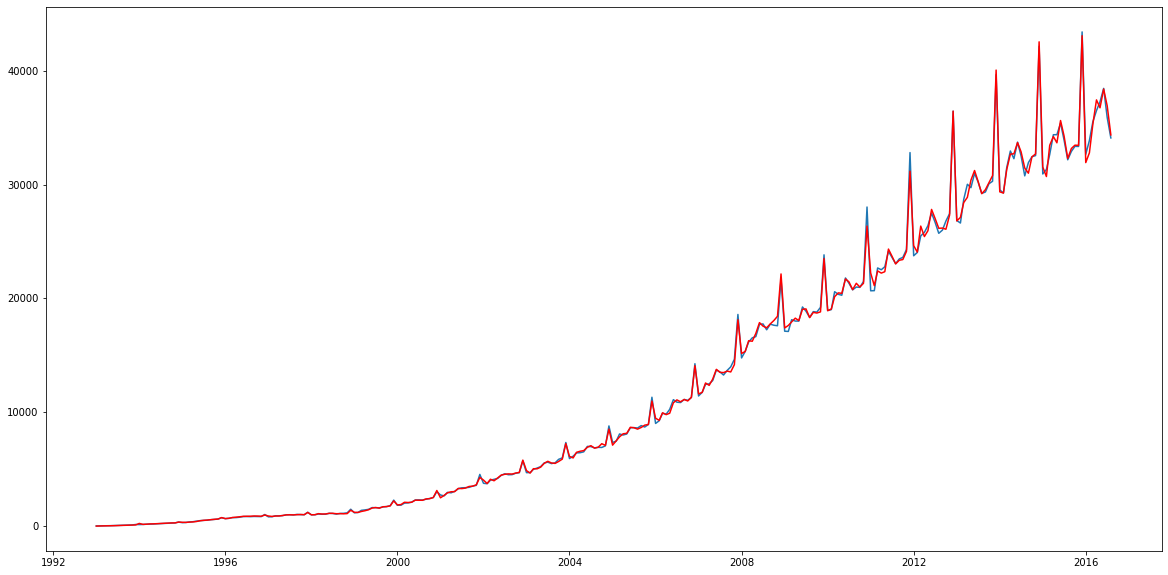

In [103]:
model = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(20, 10))
plt.plot(ts)
plt.plot(model, color='r')
plt.show()

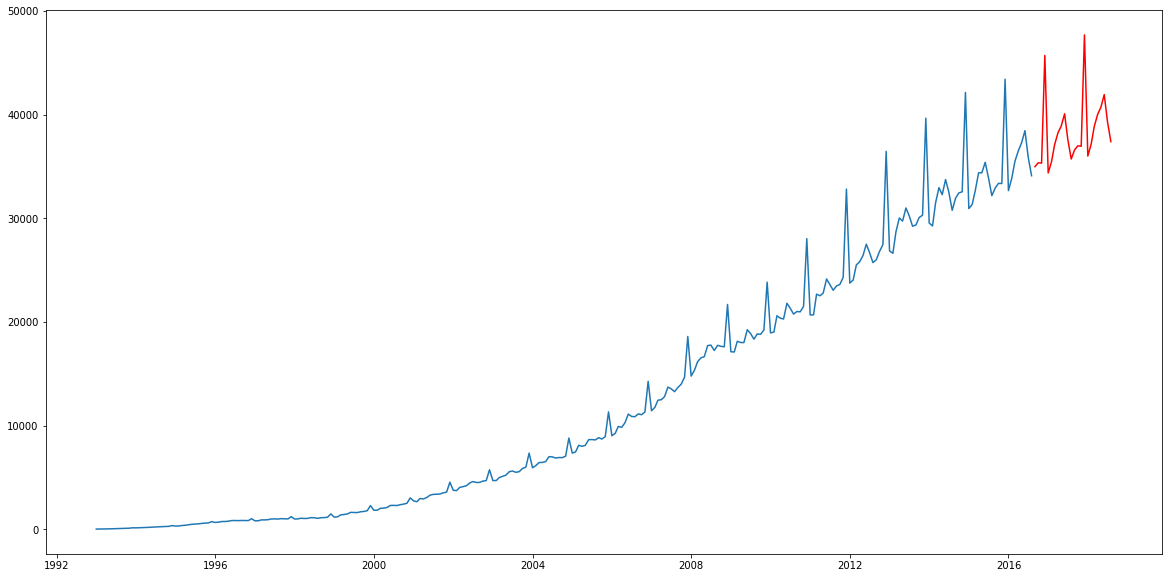

In [110]:
forecast = invboxcox(best_model.forecast(24), lmbda)
plt.figure(figsize=(20, 10))
plt.plot(ts)
plt.plot(forecast, color='r')
plt.show()